# Generate simulated PMT pulse

David Cussans , December 2025

First import the libraries we need

In [1]:
!pip install scikit-rf

In [2]:
import numpy as np
import scipy
import skrf
import matplotlib.pyplot as plt

Define routine that produces a power spectral density by interpolating from an array of values

In [3]:
def interpolate_psd(freqs_data, psd_data, n_samples, fs):
    """
    Interpolate measured PSD data onto FFT frequency grid.
    
    Parameters:
    -----------
    freqs_data : ndarray
        Frequencies of the measured PSD (GHz).
    psd_data : ndarray
        PSD values at freqs_data.
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (GHz).
    
    Returns:
    --------
    freqs_fft : ndarray
        FFT frequency bins.
    psd_interp : ndarray
        PSD values interpolated onto FFT bins.
    """
    freqs_fft = scipy.fft.rfftfreq(n_samples, 1/fs)
    psd_interp = np.interp(freqs_fft, freqs_data, psd_data, left=0, right=0)
    return freqs_fft, psd_interp

In [79]:
def get_interpolated_cable_attenuation(fname, n_samples, fs):
    """
    Interpolate measured cable attenuation data onto FFT frequency grid.
    
    Parameters:
    -----------
    fname : string
        file containing touchstone cable attenuation data.
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (GHz).
    
    Returns:
    --------
    freqs_fft : ndarray
        FFT frequency bins.
    cable_voltage_attenuation_interp : ndarray
        cable voltage attenuation interpolated onto FFT bins.
    """
    freqs_fft = scipy.fft.rfftfreq(n_samples, 1/fs)

    cable_attenuation = skrf.network_2_dataframe(skrf.Network(xlzdDirectory + '/' + fname ))
    
    print(cable_attenuation)
    
    power_attenuation_data = cable_attenuation["s_db 21"].to_numpy()

    voltage_attenuation_data = 10**(power_attenuation_data / 20)
    
    # Get frequency measurement points and convert from Hz to GHz
    freqs_data = cable_attenuation.index.to_numpy()/1000000000

    cable_voltage_attenuation_interp = np.interp(freqs_fft, freqs_data, voltage_attenuation_data, left=0, right=0)
    
    return freqs_fft, cable_voltage_attenuation_interp

Given a PSD generate a time series of the noise

In [80]:
def noise_from_psd_array(psd_vals, n_samples=1024, fs=1.0):
    """
    Generate a noise time series with a given power spectral density (PSD array).
    """
    
    # Return the Discrete Fourier Transform sample frequencies (for usage with rfft, irfft).
    # d = Sample spacing (inverse of the sampling rate)
    freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    assert len(psd_vals) == len(freqs), "PSD array length mismatch"

    # Random phases
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))

    # Amplitudes scaled by PSD
    amplitudes = np.sqrt(psd_vals * fs * n_samples / 2.0) * random_phases

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitudes)] = amplitudes
    spectrum[-(len(amplitudes)-1):] = np.conj(amplitudes[1:][::-1])

    # Inverse FFT
    x = scipy.fft.ifft(spectrum).real
    t = np.arange(n_samples) / fs

    # Verify PSD
    Xf = scipy.fft.rfft(x)
    psd_est = (np.abs(Xf) ** 2) / (fs * n_samples)

    return t, x, freqs, psd_est

Function to return white noise

In [81]:
def white_noise_array(n_samples=1024, fs=1.0):
    """
    Generate a noise time series with a flat time distribution (white noise)
    
    Parameters:
    -----------
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (GHz).
    
    Returns:
    --------
    t : ndarray
        Time bins
    x : ndarray
        Amplitude values (time series)
    freqs : ndarray
        FFT frequency bins.
    psd_interp : ndarray
        PSD values interpolated onto FFT bins.
    
    """
    
    # Return the Discrete Fourier Transform sample frequencies (for usage with rfft, irfft).
    # d = Sample spacing (inverse of the sampling rate)
    freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    #assert len(psd_vals) == len(freqs), "PSD array length mismatch"

    # Random phases
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))

    # Amplitudes- flat PSD
    psd_vals = np.array(len(freqs)*[1.0])
    print(psd_vals)
    #amplitudes = np.sqrt( fs * n_samples / 2.0) * random_phases
    amplitudes = 1.0 * random_phases

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitudes)] = amplitudes
    spectrum[-(len(amplitudes)-1):] = np.conj(amplitudes[1:][::-1])

    # Inverse FFT
    x = scipy.fft.ifft(spectrum).real
    #t = np.arange(n_samples) / fs
    t = np.linspace( start = -0.5*n_samples/fs, stop = 0.5*n_samples/fs , num=n_samples )

    # Verify PSD
    Xf = scipy.fft.rfft(x)
    psd_est = (np.abs(Xf) ** 2) / (fs * n_samples)

    return t, x, freqs, psd_est

In [82]:
def gaussian_func(x, mu, sig):
    # normalization = 1.0 / (np.sqrt(2.0 * np.pi) * sig)  
    normalization = 1.0
    y = normalization * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    return ( y)

In [83]:
def gaussian_time_domain(n_samples=1024, fs=1.0 , centre_offset = 0.5 , time_width=10.0 , peak_height=1.0):
    """
    Generate a time series of a Gaussian

    Parameters:
    -----------
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (GHz).
    centre_offset : float
        Centre of the Gaussian in the samples. With respect to the mid point. Units of 1/fs
    time_width : float
        Width(sigma) of the Gaussian in units of nano-seconds ( i.e. 1/fs )
    peak_height : float

    Returns:
    --------

    time_values : ndarray
        Time value of each sample

    amplitude_values : ndarray
        Amplitude of each value

    amplitude_freqs : ndarray
        Frequency points in FFT

    amplitude_fft : FFT of Gaussian
        
    """

    # for now force centre_pos to be 0.5
    time_values = np.linspace( start = -0.5*n_samples/fs, stop = 0.5*n_samples/fs , num=n_samples )

    amplitude_values = peak_height * gaussian_func(x = time_values, mu = centre_offset , sig = time_width )

    amplitude_freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    amplitude_fft = scipy.fft.rfft(amplitude_values)

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitude_fft)] = amplitude_fft
    spectrum[-(len(amplitude_fft)-1):] = np.conj(amplitude_fft[1:][::-1])

    print("n samples = ", n_samples)
    print("length of amplitude_freqs" , len(amplitude_freqs))
    print("Spectrum length" , len(spectrum))
    print("Spectrum" , spectrum)
    print("amplitude fft" , amplitude_fft)
    
    #plt.plot(time_values, amplitude_values)
    #plt.show()

    return time_values , amplitude_values , amplitude_freqs , amplitude_fft 
        

In [84]:
def generate_pulse_with_noise(n_samples=1024, fs=1.0 , time_offset=0.0 , time_width=10.0 , peak_height=1.0, noise_amp = 0.1):

    """
    Generate a time series of a Gaussian with added white noise

    Parameters:
    -----------
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (GHz).
    time_offset : float
        Offset between the centre of the Gaussian and the centre of the samples. Units of samples
    time_width : float
        Width(sigma) of the Gaussian in units of nano-seconds ( i.e. 1/fs )
    peak_height : float
        Hight of Gaussian
    noise_amp : float
        RMS of noise (not used at the moment)

    Returns:
    --------

    gaussian_t : ndarray
        Time value of each sample

    gaussian_amp_with_noise : ndarray
        Amplitude of each value
        
    """
    
    # Generate noise
    #t, noise_amp, freqs, psd_est = noise_from_psd_array(psd_vals, n_samples, fs)
    t, noise_time_samples, freqs, psd_est = white_noise_array(n_samples, fs)
    #noise_histo = np.histogram(noise_amp)
    #print(noise_histo)
    
    gaussian_t, gaussian_amp , amplitude_freqs, amplitude_fft = gaussian_time_domain(n_samples=n_samples , fs=fs , centre_offset = time_offset , time_width= time_width , peak_height= peak_height)

    gaussian_amp_with_noise = gaussian_amp + noise_time_samples
    print("len(gaussian_amp_with_noise)",len(gaussian_amp_with_noise))

    # Plot
    #plt.figure(figsize=(12,12))
    #plt.subplot(2,2,1)
    fig, axs = plt.subplots(2, 2)

    axs[0,0].plot(t, noise_time_samples)
    axs[0,0].set_title("Generated Noise (time series)")
    axs[0,0].set_xlabel("Time [ns]")
    axs[0,0].set_ylabel("Amplitude")

    #plt.subplot(2,2,2)
    axs[0,1].set_title("Histogram of noise values")
    axs[0,1].set_xlabel("Amplitude [arb units]")
    axs[0,1].set_ylabel("Occurance")
    axs[0,1].hist(noise_time_samples)

    #plt.subplot(2,2,3)
    axs[1,0].loglog(freqs, psd_est, label="Estimated PSD")
    axs[1,0].loglog(freqs_measured, psd_measured, 'o--', label="Measured PSD (input)")
    # axs[0,0].loglog(freqs, psd_vals, '--', label="Interpolated PSD")
    axs[1,0].set_title("Power Spectral Density")
    axs[1,0].set_xlabel("Frequency [GHz]")
    axs[1,0].set_ylabel("PSD")
    
    plt.tight_layout()
    # plt.legend()
    plt.show()

    return gaussian_t , gaussian_amp_with_noise

Read cable propagation from disk

In [85]:

rg400_data_50metres = skrf.Network(xlzdDirectory + '/habia_rg400_100metres_librevna_two-1m-cables_1M_500M_1024pts.s1p.s2p')

Use the routines to generate a time series of noise with a given PSD

                 s_db 11     s_db 21     s_db 12     s_db 22
0.000000e+00 -160.000000   -0.175478   -0.175478 -160.000000
1.000000e+06  -17.582851   -0.503995   -0.507601  -17.965284
1.487781e+06  -19.966547   -0.798756   -0.776981  -20.186311
1.975562e+06  -23.148123   -0.859244   -0.859397  -23.426200
2.463343e+06  -23.824991   -0.896245   -0.896089  -24.032578
...                  ...         ...         ...         ...
4.990244e+08  -36.485635  -16.229939  -16.236384  -40.761207
4.995122e+08  -36.634145  -16.238639  -16.242546  -40.147754
5.000000e+08  -36.980526  -16.248361  -16.254963  -39.465759
1.000000e+09  -36.980526  -25.376020  -25.376020  -39.465759
6.000000e+10 -116.989700 -116.989700 -116.989700 -116.989700

[1027 rows x 4 columns]
[1. 1. 1. ... 1. 1. 1.]
n samples =  16384
length of amplitude_freqs 8193
Spectrum length 16384
Spectrum [ 50.12950564+0.j         -50.12803043-0.00961193j
  50.12360505+0.01922216j ... -50.11623027+0.028829j
  50.12360505-0.01922216j -50.1280

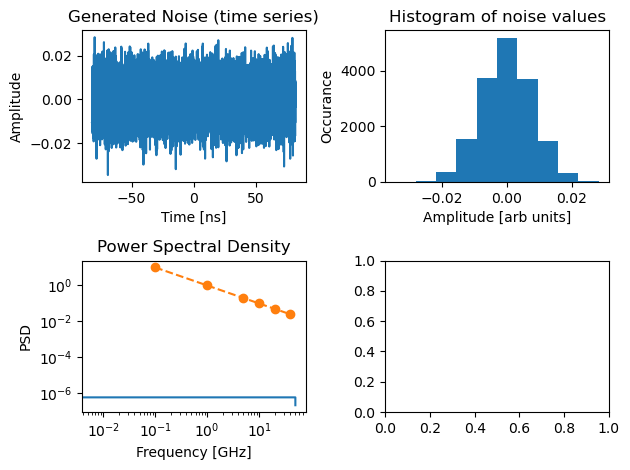

len(filtered_gaussian_with_noise_timedomain) 16384
gaussian_with_noise_deltas [ 0.01038332  0.01033291  0.00784861 ...  0.00376886 -0.00601679
  0.00251192]
filtered_gaussian_with_noise_timedomain [-0.00021946 -0.00027869 -0.00014558 ...  0.00021952  0.00039788
  0.00012049]


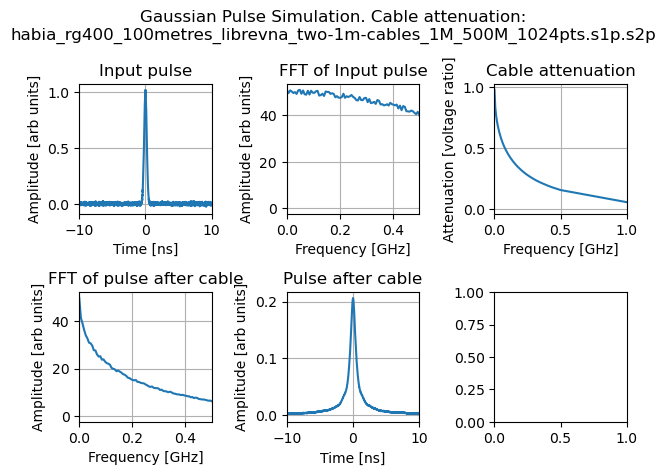

In [104]:
if __name__ == "__main__":
    fs = 100.0     # Sampling frequency (GHz), i.e. 100 = 10ps
    n_samples = 16384
    xlzdDirectory = '../data/VNA_Measurements/rg316'
    fname = 'habia_rg400_100metres_librevna_two-1m-cables_1M_500M_1024pts.s1p.s2p'

    freqs_fft, cable_attenuation_interp = get_interpolated_cable_attenuation(fname, n_samples, fs) 
    
    # Example "measured" PSD (say, pink noise, but sampled sparsely)
    #freqs_measured = np.array([0.1, 1, 5, 10, 20, 40])
    #psd_measured = 1.0 / freqs_measured  # just a toy example
    # Interpolate onto FFT grid
    # freqs_fft, cable_attenuation_interp = freqs_fft, psd_vals = interpolate_psd(freqs_measured, psd_measured, n_samples, fs)

    gaussian_t , gaussian_amp_with_noise = generate_pulse_with_noise(n_samples=n_samples, fs=fs , time_offset=0.0 , time_width=0.2 , peak_height=1.0, noise_amp=1.0)

    amplitude_freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    gaussian_with_noise_fft = scipy.fft.rfft(gaussian_amp_with_noise)

    filtered_gaussian_with_noise_fft = gaussian_with_noise_fft * cable_attenuation_interp

    filtered_gaussian_with_noise_timedomain = scipy.fft.irfft(filtered_gaussian_with_noise_fft).real
    print("len(filtered_gaussian_with_noise_timedomain)",len(filtered_gaussian_with_noise_timedomain))

    gaussian_with_noise_deltas = filtered_gaussian_with_noise_timedomain - gaussian_amp_with_noise
    print("gaussian_with_noise_deltas",gaussian_with_noise_deltas)
    
    print("filtered_gaussian_with_noise_timedomain" , filtered_gaussian_with_noise_timedomain)
    # print("Gaussian" , gaussian_t , gaussian_amp)
    
    
    

    #ax = plt.subplot(3,3,3)
    fig, axs = plt.subplots(2, 3)
    fig.figsize=(24,24)
    fig.suptitle("Gaussian Pulse Simulation. Cable attenuation:\n" + fname )
    
    # Plot input pulse with noise
    axs[0,0].set_xlim(left = -10 , right=10)
    axs[0,0].plot(gaussian_t, gaussian_amp_with_noise )
    axs[0,0].set_title("Input pulse")
    axs[0,0].set_xlabel("Time [ns]")
    axs[0,0].set_ylabel("Amplitude [arb units]")
    axs[0,0].grid()

    # Plot FFT of input pulse
    axs[0,1].set_xlim(right=0.5)
    axs[0,1].plot(amplitude_freqs, np.abs(gaussian_with_noise_fft ))
    axs[0,1].set_title("FFT of Input pulse")
    axs[0,1].set_xlabel("Frequency [GHz]")
    axs[0,1].set_ylabel("Amplitude [arb units]")
    axs[0,1].grid()

    axs[0,2].set_xlim(right=1.0)
    axs[0,2].set_title("Cable attenuation")
    axs[0,2].set_ylabel("Attenuation [voltage ratio]")
    axs[0,2].set_xlabel("Frequency [GHz]")
    axs[0,2].plot(freqs_fft, cable_attenuation_interp)
    axs[0,2].grid()
    
    axs[1,0].set_xlim(right=0.5)
    axs[1,0].plot(amplitude_freqs, np.abs(filtered_gaussian_with_noise_fft ))
    axs[1,0].set_title("FFT of pulse after cable")
    axs[1,0].set_xlabel("Frequency [GHz]")
    axs[1,0].set_ylabel("Amplitude [arb units]")
    axs[1,0].grid()
    
    #Plot pulse after cable
    axs[1,1].set_xlim(left = -10 , right=10)
    axs[1,1].set_title("Pulse after cable")
    axs[1,1].set_ylabel("Amplitude [arb units]")
    axs[1,1].set_xlabel("Time [ns]")
    axs[1,1].plot(gaussian_t, filtered_gaussian_with_noise_timedomain)
    axs[1,1].grid()
    
    #axs[0,0].subplot(3,3,7)
    #axs[1,1].set_title("Error Histo")
    #axs[1,1].set_xlabel("Amplitude [arb units]")
    #axs[1,1].set_ylabel("Occurance")
    #axs[1,1].hist(gaussian_with_noise_deltas)



 
    
    # plt.legend()
    plt.tight_layout()

    plt.savefig("../plots/" + fname + "_simulated_pulse.pdf")
    
    plt.show()

In [71]:
print( freqs_measured)

[ 0.1  1.   5.  10.  20.  40. ]


In [11]:
print(psd_measured)

[10.     1.     0.2    0.1    0.05   0.025]


In [12]:
print(freqs_fft, psd_vals)

[0.00000000e+00 6.10351562e-03 1.22070312e-02 ... 4.99877930e+01
 4.99938965e+01 5.00000000e+01] [0. 0. 0. ... 0. 0. 0.]


In [13]:
print(len(psd_vals))

8193


In [14]:
print(psd_vals[1000])

0.17792968750000002
